<div id="Introduction">
    
# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model using <b>ASL Citizen</b> Dataset
            
**<h3> Sections:**
* [Importing Libraries](#Importing_Libraries)
* [Data Loading](#Data_Loading)
* [Label Encoding](#Label_Encoding)
* [Data Augmentation](#Data_Augmentation)
* [Model Training](#Model_Training)
* [Model Visualization](#Model_Visualization)
* [Extras](#Extras)

---

<div id="Importing_Libraries">
    
# **Importing Libraries**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [1]:
import os
import gc
import cv2
import json
import time
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

In [2]:
!pip install -q tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
tfa.register_all(custom_kernels=False)
clear_output()

In [3]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[]

In [4]:
# os.makedirs('Backup',exist_ok=True)
# os.makedirs('Checkpoint',exist_ok=True)
# os.makedirs('Labels',exist_ok=True)
# os.makedirs('Models',exist_ok=True)
# os.makedirs('None',exist_ok=True)

In [5]:
# shutil.copytree('/kaggle/input/data-generator-experiment-output/Backup', '/kaggle/working/Backup')
# shutil.copytree('/kaggle/input/data-generator-experiment-output/Checkpoints', '/kaggle/working/Checkpoints')
# shutil.copytree('/kaggle/input/data-generator-experiment-output/Labels', '/kaggle/working/Labels')
# shutil.copytree('/kaggle/input/data-generator-experiment-output/Models', '/kaggle/working/Models')
# shutil.copytree('/kaggle/input/data-generator-experiment-output/None', '/kaggle/working/None')

In [5]:
# os.remove('/kaggle/working/Checkpoints/training.csv')
# shutil.rmtree('/kaggle/working/Backup')

---

<div id="Data_Loading">
    
# **Data Loading**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [23]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
len(data)

83399

In [24]:
labels = []
with open('/kaggle/input/asl-citizen-encoded/Data/labels.txt', 'r') as file:
    labels = file.read().splitlines()
len(labels)

2299

In [25]:
label_dict = dict(zip(data['video'], data['label']))

In [26]:
def load_data(dataset, split):
    files = []
    labels = []
    folder = os.path.join(dataset, split)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        video_name = os.path.splitext(file)[0] + '.mp4'
        label = label_dict.get(video_name)
        files.append(file_path)
        labels.append(label)
    return files, labels

In [27]:
all_train_files = []
all_val_files = []
all_test_files = []

all_train_labels = []
all_val_labels = []
all_test_labels = []

root_dir = '/kaggle/input'
for dataset_num in range(1, 6):
    dataset_dir = os.path.join(root_dir, f'npy-landmarks-{dataset_num}')
    
    train_files, train_labels = load_data(dataset_dir, 'train')
    val_files, val_labels = load_data(dataset_dir, 'val')
    test_files, test_labels = load_data(dataset_dir, 'test')
    
    all_train_files.extend(train_files)
    all_train_labels.extend(train_labels)
    
    all_val_files.extend(val_files)
    all_val_labels.extend(val_labels)
    
    all_test_files.extend(test_files)
    all_test_labels.extend(test_labels)
    

print("Total Train files:", len(all_train_files))
print("Total Validation files:", len(all_val_files))
print("Total Test files:", len(all_test_files))

Total Train files: 40154
Total Validation files: 10304
Total Test files: 32941


In [28]:
for file in os.listdir('/kaggle/input/data-generator-experiment-output/None'):
    file_path = os.path.join('/kaggle/input/data-generator-experiment-output/None', file)
    all_train_files.append(file_path)
    all_train_labels.append('None')

In [29]:
seed_value = 42
np.random.seed(seed_value)

permutation_train = np.random.permutation(len(all_train_labels))
permutation_val = np.random.permutation(len(all_val_labels))
permutation_test = np.random.permutation(len(all_test_labels))

all_train_files = [all_train_files[i] for i in permutation_train]
all_train_labels = [all_train_labels[i] for i in permutation_train]

all_val_files = [all_val_files[i] for i in permutation_val]
all_val_labels = [all_val_labels[i] for i in permutation_val]

all_test_files = [all_test_files[i] for i in permutation_test]
all_test_labels = [all_test_labels[i] for i in permutation_test]

In [30]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [4, 6, 8, 9, 33, 37, 40, 46, 52, 55, 61, 70, 80, 82, 84,
                 87, 88, 91, 105, 107, 133, 145, 154, 157, 159, 161, 163,
                 263, 267, 270, 276, 282, 285, 291, 300, 310, 312, 314, 317,
                 318, 321, 334, 336, 362, 374, 381, 384, 386, 388, 390, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [31]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 52, 54, 56, 57, 81, 85, 88, 94, 100, 103, 109, 118, 128, 130, 132, 135, 136, 139, 153, 155, 181, 193, 202, 205, 207, 209, 211, 311, 315, 318, 324, 330, 333, 339, 348, 358, 360, 362, 365, 366, 369, 382, 384, 410, 422, 429, 432, 434, 436, 438, 516, 521]

Total Number: 100


---

<div id="Label_Encoding">
    
# **Label Encoding**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [32]:
glosses = pd.unique(all_train_labels) # preserve order
len(glosses)

/tmp/ipykernel_33/1264778156.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  glosses = pd.unique(all_train_labels) # preserve order


2732

In [33]:
gloss_mapping = {gloss: idx for idx, gloss in enumerate(glosses)}
with open(f'/kaggle/working/Labels/{len(glosses)}_gloss_mapping.json', 'w') as json_file:
    json.dump(gloss_mapping, json_file, indent=4)
    
index_gloss_mapping = {idx: gloss for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Labels/{len(glosses)}_index_gloss_mapping.json', 'w') as json_file:
    json.dump(index_gloss_mapping, json_file, indent=4)

In [34]:
gloss_to_label = data[['label', 'clean label']].set_index('label').to_dict()['clean label']
gloss_to_label['None'] = 'None'

index_label_mapping = {idx: gloss_to_label[gloss] for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Labels/{len(glosses)}_index_label_mapping.json', 'w') as json_file:
    json.dump(index_label_mapping, json_file, indent=4)

In [35]:
all_train_labels= [gloss_mapping[label] for label in all_train_labels]
all_val_labels = [gloss_mapping[label] for label in all_val_labels]
all_test_labels = [gloss_mapping[label] for label in all_test_labels]

In [36]:
all_train_labels[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [37]:
gc.collect()

2647

---

<div id="Data_Augmentation">
    
# **Data Augmentation**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [38]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

In [39]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

In [40]:
def apply_augmentations(data, forced=False):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask]
    np.random.shuffle(aug_functions)
    if forced:
        data = aug_functions[0](data)
        return data
    
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data, forced=True)

    return data

In [41]:
def augment(X, Y):
    num_samples = tf.shape(Y)[0]
    def augment_single_sample(i):
        return apply_augmentations(X[i])
    
    with ThreadPoolExecutor() as executor:
        X_aug = np.array(list(executor.map(augment_single_sample, range(num_samples))))
        
    X_aug = tf.concat([X, X_aug], axis=0)
    Y_aug = tf.concat([Y, Y], axis=0)
    return X_aug, Y_aug

---

<div id="Model_Training">
    
# **Model Training**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [42]:
def preprocess(X, Y, aug=True):
    X = np.array(X)[:,:,landmarks,:]
    Y = np.array(Y, dtype=np.float32)
    if aug:
        X, Y = augment(X, Y)
    return X, Y

In [43]:
from joblib import Parallel, delayed

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, label_list, batch_size=32, shuffle=False, aug=False):
        self.file_list = file_list
        self.label_list = label_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.file_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.label_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = Parallel(n_jobs=-1)(delayed(np.load)(file) for file in batch_files)
        return preprocess(batch_data, batch_labels, self.aug)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)
            
train_generator = DataGenerator(all_train_files + all_test_files , all_train_labels + all_test_labels , batch_size=128, aug=True)
val_generator = DataGenerator(all_val_files, all_val_labels, batch_size=128, aug=False)
# test_generator = DataGenerator(all_test_files, all_test_labels, batch_size=128, aug=False)

In [44]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):

    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))

    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [45]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [46]:
class OneCycleLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                lr=1e-4,
                epochs=10,
                steps_per_epoch=100,
                steps_per_update=1,
                resume_epoch=0,
                decay_epochs=10,
                sustain_epochs=0,
                warmup_epochs=0,
                lr_start=0,
                lr_min=0,
                warmup_type='linear',
                decay_type='cosine',
                **kwargs):
        
        super().__init__(**kwargs)
        self.lr = float(lr)
        self.epochs = float(epochs)
        self.steps_per_update = float(steps_per_update)
        self.resume_epoch = float(resume_epoch)
        self.steps_per_epoch = float(steps_per_epoch)
        self.decay_epochs = float(decay_epochs)
        self.sustain_epochs = float(sustain_epochs)
        self.warmup_epochs = float(warmup_epochs)
        self.lr_start = float(lr_start)
        self.lr_min = float(lr_min)
        self.decay_type = decay_type
        self.warmup_type = warmup_type
        

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        total_steps = self.epochs * self.steps_per_epoch
        warmup_steps = self.warmup_epochs * self.steps_per_epoch
        sustain_steps = self.sustain_epochs * self.steps_per_epoch
        decay_steps = self.decay_epochs * self.steps_per_epoch

        if self.resume_epoch > 0:
            step = step + self.resume_epoch * self.steps_per_epoch

        step = tf.cond(step > decay_steps, lambda :decay_steps, lambda :step)
        step = tf.math.truediv(step, self.steps_per_update) * self.steps_per_update

        warmup_cond = step < warmup_steps
        decay_cond = step >= (warmup_steps + sustain_steps)
        
        if self.warmup_type == 'linear':
            lr = tf.cond(warmup_cond, lambda: tf.math.divide_no_nan(self.lr-self.lr_start , warmup_steps) * step + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'exponential':
            factor = tf.pow(self.lr_start, 1/warmup_steps)
            lr = tf.cond(warmup_cond, lambda: (self.lr - self.lr_start) * factor**(warmup_steps - step) + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'cosine':
            lr = tf.cond(warmup_cond, lambda: 0.5 * (self.lr - self.lr_start) * (1 + tf.cos(3.14159265359 * (warmup_steps - step)  / warmup_steps)) + self.lr_start, lambda:self.lr)
        else:
            raise NotImplementedError
                    
        
        if self.decay_type == 'linear':
            lr = tf.cond(decay_cond, lambda: self.lr + (self.lr_min-self.lr)/(decay_steps - warmup_steps - sustain_steps)*(step - warmup_steps - sustain_steps), lambda:lr)
        elif self.decay_type == 'exponential':
            factor = tf.pow(self.lr_min, 1/(decay_steps - warmup_steps - sustain_steps))
            lr = tf.cond(decay_cond, lambda: (self.lr - self.lr_min) * factor**(step - warmup_steps - sustain_steps) + self.lr_min, lambda:lr)
        elif self.decay_type == 'cosine':
            lr = tf.cond(decay_cond, lambda: 0.5 * (self.lr - self.lr_min) * (1 + tf.cos(3.14159265359 * (step - warmup_steps - sustain_steps) / (decay_steps - warmup_steps - sustain_steps))) + self.lr_min, lambda:lr)
        else:
            raise NotImplementedError
            
        return lr

    def plot(self):
        step = max(1, int(self.epochs*self.steps_per_epoch)//1000) #1 for total_steps < 1000, total_steps//1000 else
        eps = list(range(0,int(self.epochs*self.steps_per_epoch),step))
        learning_rates = [self(x) for x in eps]
        plt.scatter(eps,learning_rates,2)
        plt.show()
        
    def get_config(self):
        config = {
            'lr': self.lr,
            'epochs': self.epochs,
            'steps_per_update': self.steps_per_update,
            'resume_epoch': self.resume_epoch,
            'steps_per_epoch': self.steps_per_epoch,
            'decay_epochs': self.decay_epochs,
            'sustain_epochs': self.sustain_epochs,
            'warmup_epochs': self.warmup_epochs,
            'lr_start': self.lr_start,
            'lr_min': self.lr_min,
            'decay_type': self.decay_type,
            'warmup_type': self.warmup_type
        }
        return config

In [47]:
def get_model(max_len=120, dropout_step=0, dim=192):
    inp = tf.keras.layers.Input(shape=(120, len(landmarks), 3), name='input')
    x = inp
    x = tf.reshape(x, [-1,120, len(landmarks) * 3])

    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    for _ in range(4):
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.5, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(len(glosses),name='classifier')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=x)
    
    schedule = OneCycleLR(8e-3, 500, steps_per_epoch=192, decay_epochs=500, lr_min=1e-6, decay_type='cosine', warmup_type='linear')
    decay_schedule = OneCycleLR(8e-4, 500, steps_per_epoch=192, decay_epochs=500, lr_min=1e-7, decay_type='cosine', warmup_type='linear')
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4.0)
    optimizer = tfa.optimizers.Lookahead(optimizer,sync_period=5)

    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
    )
    return model

In [48]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 120, 100, 3)]        0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 120, 300)             0         ['input[0][0]']               
                                                                                                  
 stem_conv (Dense)           (None, 120, 192)             57600     ['tf.reshape[0][0]']          
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 120, 192)             768       ['stem_conv[0][0]']           
 n)                                                                                           

In [ ]:
acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints/best_accuracy_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints/best_loss_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

csv_logger = tf.keras.callbacks.CSVLogger('Checkpoints/training.csv', append=True)

backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="Backup", delete_checkpoint=False)

    
try:
    hist = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=500,
        callbacks=[acc_checkpoint, loss_checkpoint, early_stopping, csv_logger, backup_callback]
    )
    
except KeyboardInterrupt:
    model.load_weights('Checkpoints/best_accuracy_weights.h5')
    print("\nManual interruption detected. Training stopped.")

Epoch 68/500
  2/571 [..............................] - ETA: 19:18 - loss: 0.7212 - accuracy: 0.8086

In [30]:
!zip -r Backup.zip Backup

  adding: Backup/ (stored 0%)
  adding: Backup/chief/ (stored 0%)
  adding: Backup/chief/ckpt-67.index (deflated 82%)
  adding: Backup/chief/ckpt-67.data-00000-of-00001 (deflated 8%)
  adding: Backup/chief/checkpoint (deflated 40%)


In [31]:
os.remove('Backup.zip')

In [52]:
model.load_weights('Checkpoints/best_accuracy_weights.h5')
# model.load_weights('Checkpoints/best_loss_weights.h5')
gc.collect()

2293

In [53]:
model.evaluate(val_generator)

80/80 [==============================] - 184s 2s/step - loss: 0.9100 - accuracy: 0.8197


[0.9099602699279785, 0.8197265863418579]

In [54]:
train_without_aug = DataGenerator(all_train_files + all_test_files, all_train_labels + all_test_labels, batch_size=128, aug=False)
model.evaluate(train_without_aug)

571/571 [==============================] - 1305s 2s/step - loss: 0.0106 - accuracy: 0.9970


[0.010575726628303528, 0.9970309734344482]

In [ ]:
# model.evaluate(test_generator)

In [ ]:
# del val_generator
# gc.collect()

---

<div id="Model_Visualization">
    
# **Model Visualization**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

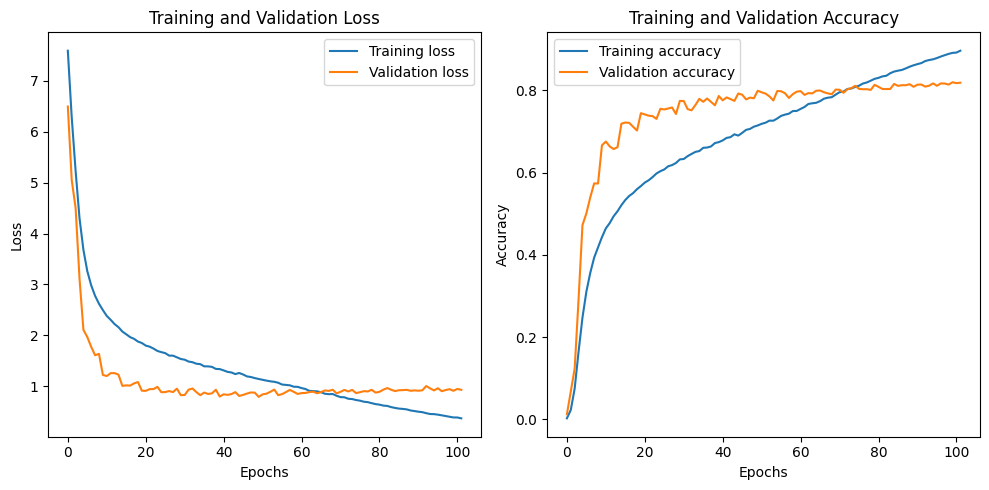

In [70]:
metrics = pd.read_csv('/kaggle/working/Checkpoints/training.csv')

train_loss = metrics['loss']
val_loss = metrics['val_loss']
train_acc = metrics['accuracy']
val_acc = metrics['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss,  label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel(f'Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel(f'Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
name = '3-27'
model_filepath = '/kaggle/working/Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}.h5')
model.save(model_filepath + f'/{name}')
converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

shutil.rmtree(model_filepath + f'/{name}')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 146, Total Ops 872, % non-converted = 16.74 %
 * 146 ARITH ops

- arith.constant:  146 occurrences  (f32: 125, i32: 21)



  (f32: 54)
  (f32: 8)
  (i32: 42)
  (f32: 12)
  (f32: 12)
  (f32: 36)
  (f32: 43)
  (i32: 84)
  (f32: 28)
  (f32: 13)
  (f32: 41)

  (i32: 50)
  (f32: 12)
  (i32: 84)
  (f32: 117)
  (i32: 50)
  (f32: 4)
  (f32: 4)
  (f32: 12, i32: 8)
  (f32: 8)


80/80 [==============================] - 192s 2s/step


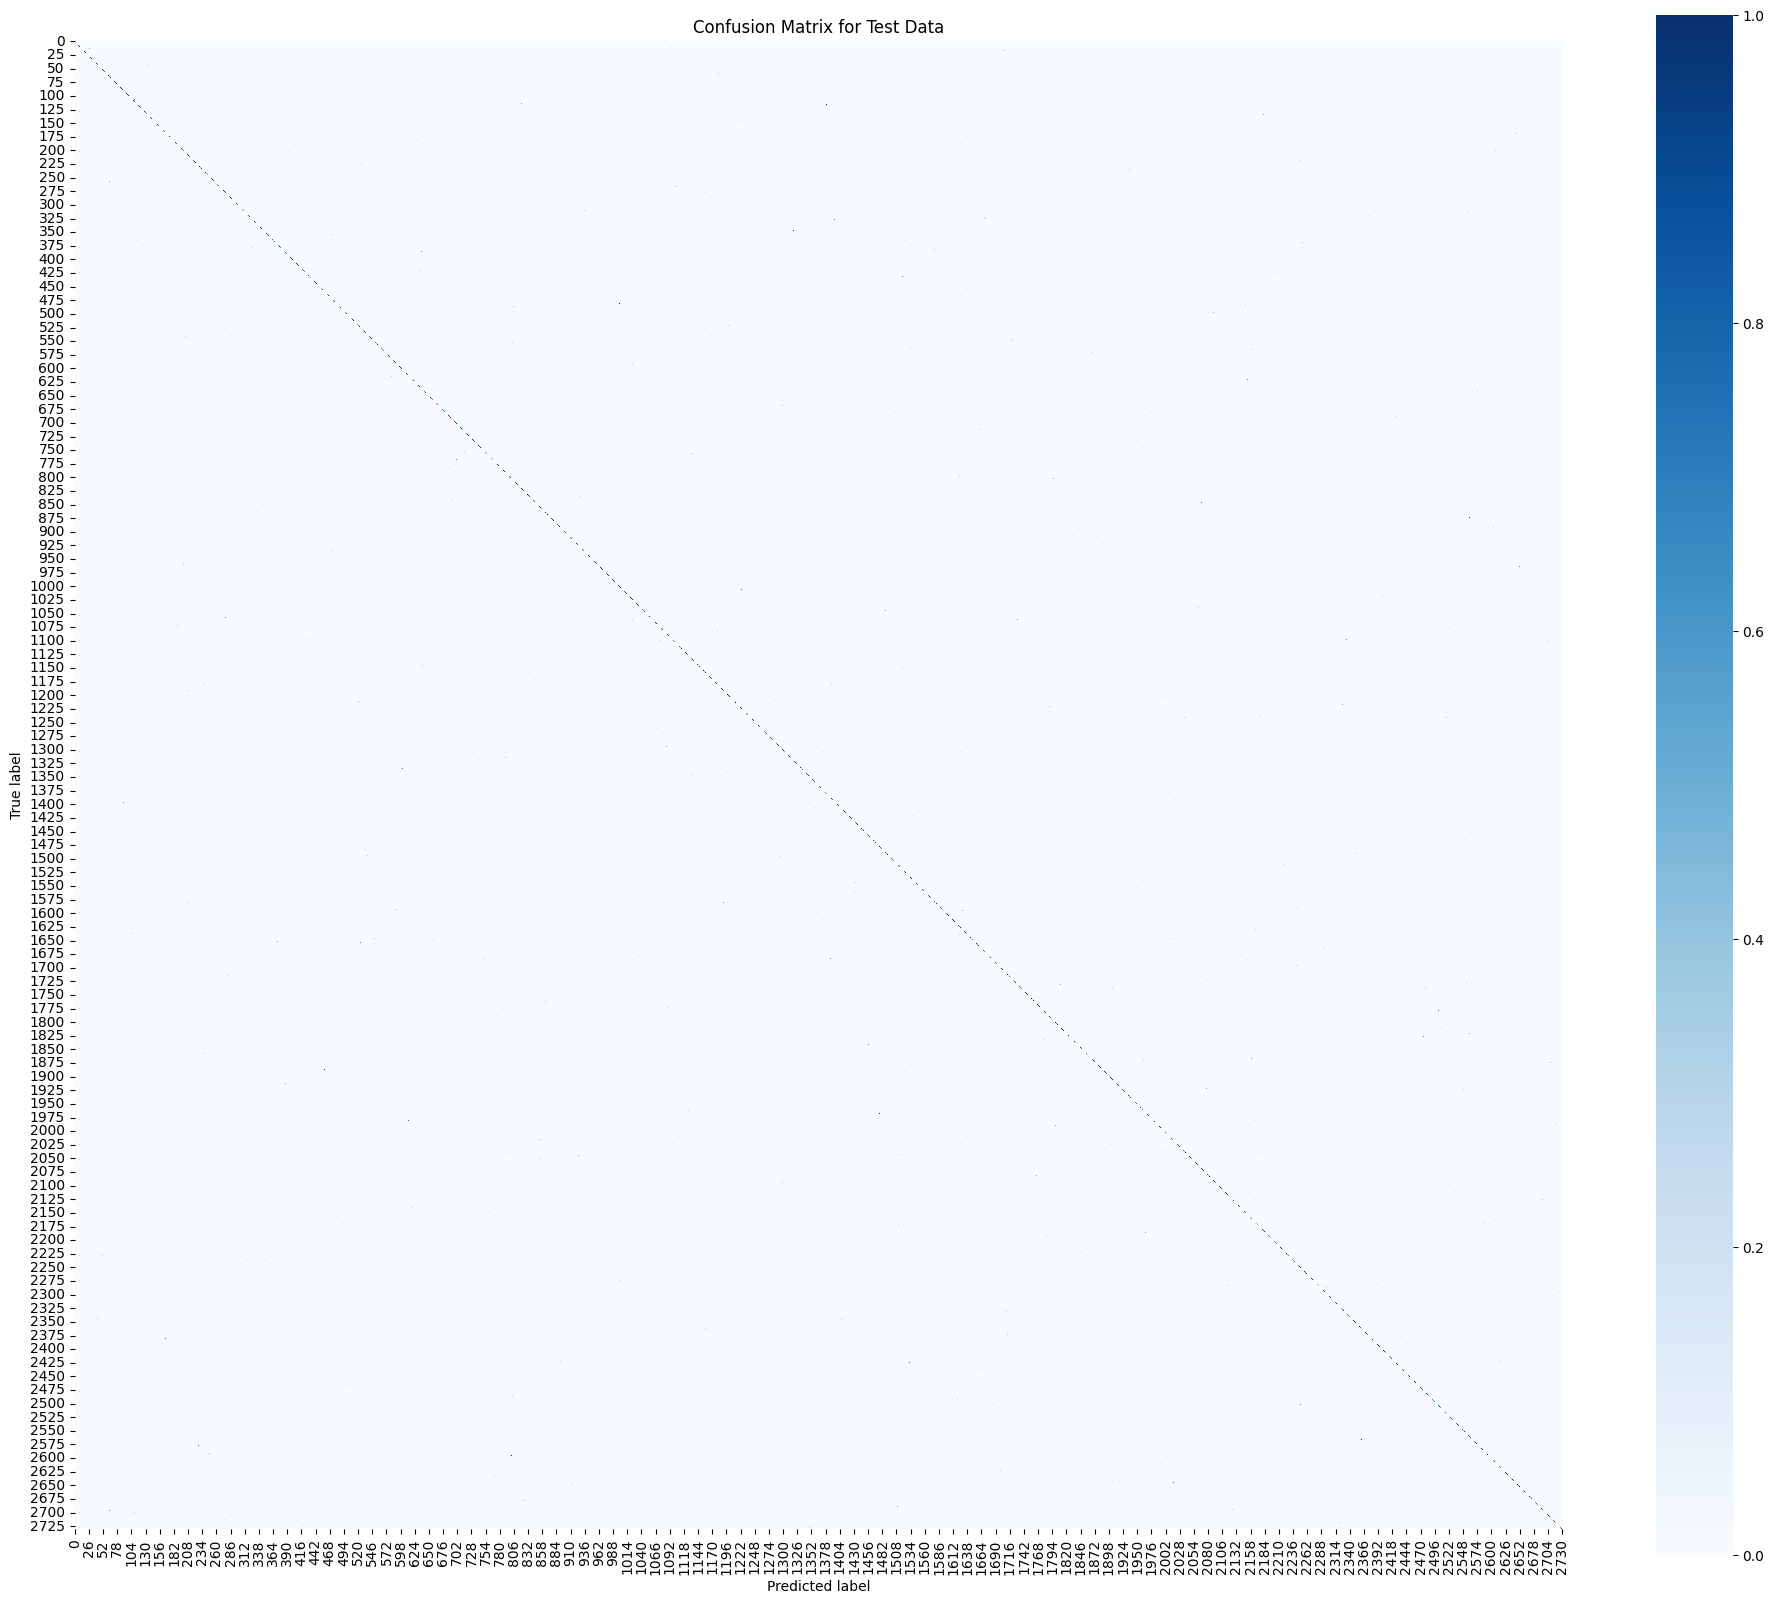

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probabilities = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)

true_labels = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    true_labels.extend(labels)

conf_matrix = confusion_matrix(true_labels, Y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, square=True)

plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [59]:
diameter = []
for i in range(conf_matrix.shape[0]):
    diameter.append(conf_matrix[i,i])

diameter = np.array(diameter)
np.mean(diameter[~np.isnan(diameter)])

0.8221765967463515

In [ ]:
# del X_test, Y_test
# gc.collect()

---

<div id="Extras">
    
# **Extras**

<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

**<h3>Refining evaluation graphs**

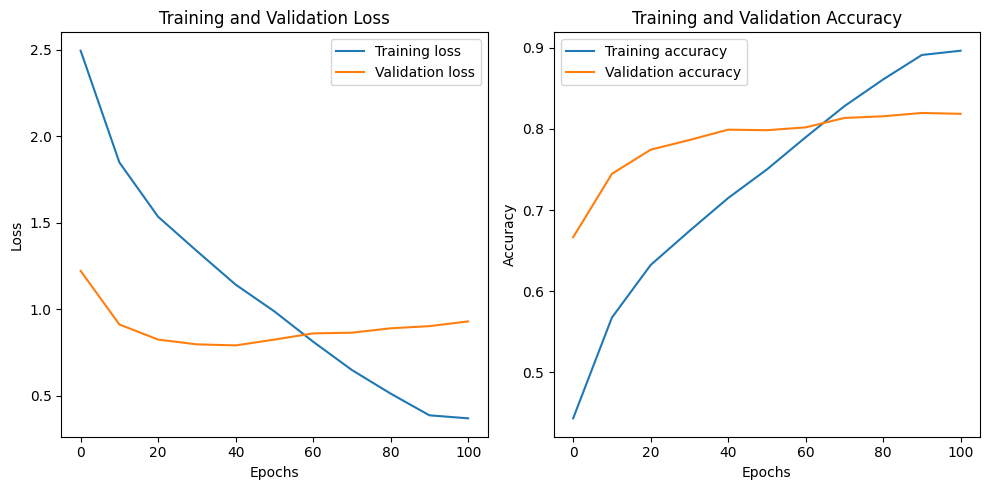

In [71]:
interval = 10
metrics = pd.read_csv('/kaggle/working/Checkpoints/training.csv')

# Get the best loss and accuracy within each interval
train_loss = [np.min(metrics['loss'][i:i+interval]) for i in range(0, len(metrics['loss']), interval)]
val_loss = [np.min(metrics['val_loss'][i:i+interval]) for i in range(0, len(metrics['val_loss']), interval)]
train_acc = [np.max(metrics['accuracy'][i:i+interval]) for i in range(0, len(metrics['accuracy']), interval)]
val_acc = [np.max(metrics['val_accuracy'][i:i+interval]) for i in range(0, len(metrics['val_accuracy']), interval)]
x_axis_values = [i*interval for i in range(len(train_loss))]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_axis_values, train_loss, label='Training loss')
plt.plot(x_axis_values, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(x_axis_values, train_acc, label='Training accuracy')
plt.plot(x_axis_values, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**<h3>Search for any video by label**

In [ ]:
# label = 'welcome'

# data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
# video_names = data.loc[(data['clean label'] == label) & (data['split'] == 'test'), 'video'].tolist()
# video_names

In [ ]:
# video_name = video_names[4]
# source_path = '/kaggle/input/asl-citizen/ASL_Citizen/videos/' + video_name
# destination_path = '/kaggle/working/'

# shutil.copy(source_path, destination_path)

In [ ]:
# os.remove(destination_path + video_name)

**<h3>Evaluate TFLite model**

In [72]:
model_path = 'Models/3-27.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(f'Input Shape: {input_shape}, Output Shape: {output_shape}')

correct_gloss = 0
correct_label = 0
count = 0

for i in tqdm(range(len(val_generator)), ncols=100):
    batch_data, batch_labels = val_generator[i]
    
    for j in range(len(batch_data)):
        single_input = batch_data[j:j+1].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], single_input)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])

        prediction = np.argmax(output, axis=1)[0]
        true_label = batch_labels[j]
        
        count += 1
        if index_label_mapping[int(prediction)] == index_label_mapping[int(true_label)]:
            correct_label += 1
            if prediction == true_label:
                correct_gloss += 1

gloss_accuracy = correct_gloss / count
label_accuracy = correct_label / count

print(f'Gloss Accuracy: {gloss_accuracy:.4f}')
print(f'Label Accuracy: {label_accuracy:.4f}')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Input Shape: [  1 120 100   3], Output Shape: [   1 2732]


100%|███████████████████████████████████████████████████████████████| 80/80 [07:06<00:00,  5.33s/it]

Gloss Accuracy: 0.8197
Label Accuracy: 0.8324


In [77]:
correct_gloss, correct_label, count, len(all_val_files)

**<h3>Neuron confidence range**

In [80]:
Y_pred = []

for i in tqdm(range(len(val_generator))):
    batch_data, _ = val_generator[i]
    output_data = model.predict(batch_data, verbose=0)
    Y_pred.append(output_data)

100%|██████████| 80/80 [04:02<00:00,  3.03s/it]


In [81]:
Y_pred = np.vstack(Y_pred)
class_idxs = np.argmax(Y_pred, axis=1)
class_idxs.shape, np.unique(class_idxs).shape

((10240,), (2712,))

In [84]:
# Calculate average prediction for each class
avg_positive = np.array([np.nanmean(Y_pred[class_idxs == cls] + 1e-6, axis=0)[cls] if np.sum(class_idxs == cls) > 0 else np.nan for cls in range(len(glosses))])
avg_negative = np.array([np.nanmean(Y_pred[class_idxs != cls] + 1e-6, axis=0)[cls] if np.sum(class_idxs != cls) > 0 else np.nan for cls in range(len(glosses))])

# Calculate standard deviation for each class
std_positive = np.array([np.nanstd(Y_pred[class_idxs == cls] + 1e-6, axis=0)[cls] if np.sum(class_idxs == cls) > 0 else np.nan for cls in range(len(glosses))])
std_negative = np.array([np.nanstd(Y_pred[class_idxs != cls] + 1e-6, axis=0)[cls] if np.sum(class_idxs != cls) > 0 else np.nan for cls in range(len(glosses))])

In [85]:
# Calculate estimated range for last layer neurons
range_positive_lower = avg_positive - 2 * std_positive
range_positive_upper = avg_positive + 2 * std_positive
range_positive = np.stack((range_positive_lower, avg_positive, range_positive_upper), axis=1)

range_negative_lower = avg_negative - 2 * std_negative
range_negative_upper = avg_negative + 2 * std_negative
range_negative = np.stack((range_negative_lower, avg_negative, range_negative_upper), axis=1)

In [86]:
f'Shape: {range_positive.shape}, Examples: {range_positive[5]}, {range_positive[9]}, {range_positive[15]}'

'Shape: (2732, 3), Examples: [34.90670872 45.55161667 56.19652462], [45.56656551 56.0463562  66.52614689], [31.34413433 43.34315109 55.34216785]'

In [94]:
range_positive[80], range_negative[80]

(array([38.34711266, 43.83766556, 49.32821846]),
 array([-18.643581 ,  -0.5815274,  17.480526 ], dtype=float32))

In [95]:
np.save('Checkpoints/range_positive.npy', range_positive)
np.save('Checkpoints/range_negative.npy', range_negative)

In [96]:
def calculate_certainty(pred, pos_range, neg_range):
    z_score_true = abs(pred - pos_range[1]) / (pos_range[2] - pos_range[0])
    z_score_false = abs(pred - neg_range[1]) / (neg_range[2] - neg_range[0])
    return z_score_false / (z_score_true + z_score_false)

In [97]:
print(f'{calculate_certainty(50, range_positive[80], range_negative[80]) * 100:.2f} %')

71.39 %


---